### installations and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
import praw

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

### fetch bitcoin data and reddit news

In [2]:
start = dt.datetime.now() - dt.timedelta(days=730)
end = dt.datetime.now()

data = yf.download('BTC-USD', start=start, end=end, interval='60m')
    
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-08-19 18:00:00,21472.294922,21477.185547,21369.193359,21377.558594,21377.558594,0
2022-08-19 19:00:00,21378.144531,21452.357422,21276.039062,21392.466797,21392.466797,806543360
2022-08-19 20:00:00,21391.539062,21391.539062,21237.187500,21302.839844,21302.839844,474300416
2022-08-19 21:00:00,21299.289062,21306.484375,21042.144531,21043.371094,21043.371094,498880512
2022-08-19 22:00:00,21043.175781,21275.783203,21007.718750,21007.718750,21007.718750,1643249664
...,...,...,...,...,...,...
2024-08-18 12:00:00,60018.019531,60262.718750,59908.742188,60017.726562,60017.726562,436197376
2024-08-18 13:00:00,60014.281250,60215.789062,59882.125000,59882.125000,59882.125000,57338880
2024-08-18 14:00:00,59858.285156,59967.011719,59693.148438,59851.429688,59851.429688,284138496


In [3]:
reddit = praw.Reddit(client_id='-DikpAFUeeajlFFyWTBqUg',
                     client_secret='yZu1rPuBINVPuI7LuugQybGwtX1Cdg',
                     user_agent='bitcoin data')

tokenizer = BertTokenizer.from_pretrained("kk08/CryptoBERT")
sentimentModel = BertForSequenceClassification.from_pretrained("kk08/CryptoBERT")
classifier = pipeline("sentiment-analysis", model=sentimentModel, tokenizer=tokenizer)

batch_size = 24 * 7 

sentiment_data = []

for i in range(0, len(data), batch_size):
    batch_start = data.index[i]
    batch_end = data.index[min(i + batch_size - 1, len(data) - 1)]

    submissions = reddit.subreddit('cryptocurrency').search('bitcoin')

    hourly_sentiments = {hour: [] for hour in pd.date_range(start=batch_start, end=batch_end, freq='h')}

    for submission in submissions:
        post_time = dt.datetime.fromtimestamp(submission.created_utc)
        
        if batch_start <= post_time <= batch_end:
            sentiment_result = classifier(submission.title)
            sentiment_score = sentiment_result[0]['score']
            sentiment_label = sentiment_result[0]['label']
            
            if sentiment_label == 'LABEL_1':
                sentiment = sentiment_score
            else:
                sentiment = -sentiment_score
            
            post_hour = post_time.replace(minute=0, second=0, microsecond=0)
            
            if post_hour in hourly_sentiments:
                hourly_sentiments[post_hour].append(sentiment)

    for hour, sentiments in hourly_sentiments.items():
        avg_sentiment = np.mean(sentiments) if sentiments else 0
        sentiment_data.append(avg_sentiment)
    
    print(f"Processed batch {i//batch_size + 1}/{len(data)//batch_size + 1}")



Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Processed batch 1/104
Processed batch 2/104
Processed batch 3/104
Processed batch 4/104
Processed batch 5/104
Processed batch 6/104
Processed batch 7/104
Processed batch 8/104
Processed batch 9/104
Processed batch 10/104
Processed batch 11/104
Processed batch 12/104
Processed batch 13/104
Processed batch 14/104
Processed batch 15/104
Processed batch 16/104
Processed batch 17/104
Processed batch 18/104
Processed batch 19/104
Processed batch 20/104
Processed batch 21/104
Processed batch 22/104
Processed batch 23/104
Processed batch 24/104
Processed batch 25/104
Processed batch 26/104
Processed batch 27/104
Processed batch 28/104
Processed batch 29/104
Processed batch 30/104
Processed batch 31/104
Processed batch 32/104
Processed batch 33/104
Processed batch 34/104
Processed batch 35/104
Processed batch 36/104
Processed batch 37/104
Processed batch 38/104
Processed batch 39/104
Processed batch 40/104
Processed batch 41/104
Processed batch 42/104
Processed batch 43/104
Processed batch 44/1

In [4]:
if len(sentiment_data) != len(data.index):
    print(f"Length mismatch: sentiment_data ({len(sentiment_data)}) vs data.index ({len(data.index)})")
    if len(sentiment_data) > len(data.index):
        sentiment_data = sentiment_data[:len(data.index)]
    else:
        sentiment_data.extend([0] * (len(data.index) - len(sentiment_data)))

data['Sentiment'] = pd.Series(sentiment_data, index=data.index[:len(sentiment_data)])

data

Length mismatch: sentiment_data (17519) vs data.index (17435)


,Open,High,Low,Close,Adj Close,Volume,Sentiment
Datetime,,,,,,,
2022-08-19 18:00:00,21472.294922,21477.185547,21369.193359,21377.558594,21377.558594,0,0.0
2022-08-19 19:00:00,21378.144531,21452.357422,21276.039062,21392.466797,21392.466797,806543360,0.0
2022-08-19 20:00:00,21391.539062,21391.539062,21237.187500,21302.839844,21302.839844,474300416,0.0
2022-08-19 21:00:00,21299.289062,21306.484375,21042.144531,21043.371094,21043.371094,498880512,0.0
2022-08-19 22:00:00,21043.175781,21275.783203,21007.718750,21007.718750,21007.718750,1643249664,0.0
...,...,...,...,...,...,...,...
2024-08-18 12:00:00,60018.019531,60262.718750,59908.742188,60017.726562,60017.726562,436197376,0.0
2024-08-18 13:00:00,60014.281250,60215.789062,59882.125000,59882.125000,59882.125000,57338880,0.0
2024-08-18 14:00:00,59858.285156,59967.011719,59693.148438,59851.429688,59851.429688,284138496,0.0


### prepare data

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(data[['Close', 'Sentiment']].values)

prediction_hours = 24 * 7

test_days = 30
test_data_points = test_days * 24 

train_data = scaled_data[:-test_data_points]
test_data = scaled_data[-test_data_points:]

x_train, y_train = [], []

for x in range(prediction_hours, len(train_data)):
    x_train.append(train_data[x-prediction_hours:x])
    y_train.append(train_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))

x_test, y_test = [], []

for x in range(prediction_hours, len(test_data)):
    x_test.append(test_data[x-prediction_hours:x])
    y_test.append(test_data[x, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (16547, 168, 2)
y_train shape: (16547,)
x_test shape: (552, 168, 2)
y_test shape: (552,)


### create and train neural network

In [6]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
518/518 [==============================] - 28s 42ms/step - loss: 0.0038
Epoch 2/25
518/518 [==============================] - 21s 41ms/step - loss: 0.0015
Epoch 3/25
518/518 [==============================] - 21s 40ms/step - loss: 0.0012
Epoch 4/25
518/518 [==============================] - 21s 40ms/step - loss: 0.0011
Epoch 5/25
518/518 [==============================] - 21s 40ms/step - loss: 9.6534e-04
Epoch 6/25
518/518 [==============================] - 21s 41ms/step - loss: 8.3464e-04
Epoch 7/25
518/518 [==============================] - 21s 40ms/step - loss: 8.2609e-04
Epoch 8/25
518/518 [==============================] - 21s 41ms/step - loss: 7.6387e-04
Epoch 9/25
518/518 [==============================] - 21s 41ms/step - loss: 7.7377e-04
Epoch 10/25
518/518 [==============================] - 23s 44ms/step - loss: 7.7332e-04
Epoch 11/25
518/518 [==============================] - 25s 48ms/step - loss: 7.2295e-04
Epoch 12/25
518/518 [==============================] - 24

### predict

In [13]:
future_hours = 24 

last_data = test_data[-prediction_hours:]

predicted_prices = []

for i in range(future_hours):
    last_data_reshaped = np.reshape(last_data, (1, last_data.shape[0], 2))
    
    predicted_price = model.predict(last_data_reshaped)
    
    predicted_prices.append(predicted_price[0, 0])
    
    new_data_point = np.array([[predicted_price[0, 0], 0]])
    last_data = np.vstack([last_data[1:], new_data_point])

predicted_prices = scaler.inverse_transform([[price, 0] for price in predicted_prices])[:, 0]

actual_prices = data['Close'][-test_data_points:][-future_hours:].values

1/1 [==============================] - 0s 35ms/step


In [14]:
predicted_prices

array([60687.48351317, 61067.84439985, 61785.59803558, 62771.13783261,
       63937.83013791, 65204.50984495, 66503.87654598, 67781.54858391,
       68992.96282838, 70101.81420664, 71080.78760501, 71913.30476566,
       72594.83618541, 73132.29349944, 73541.65425404, 73844.08144805,
       74062.0706933 , 74216.23261021, 74323.60116882, 74397.10202453,
       74446.01513509, 74476.83785185, 74494.17563002, 74501.425597  ])

In [15]:
actual_prices

array([59471.57421875, 59425.55859375, 59484.75      , 59422.234375  ,
       59295.75      , 59312.66796875, 59446.26171875, 59698.60546875,
       59453.8125    , 59980.6015625 , 59354.28515625, 59452.12109375,
       59508.1171875 , 59589.11328125, 59575.        , 59688.8671875 ,
       59901.95703125, 59907.234375  , 59999.40625   , 60017.7265625 ,
       59882.125     , 59851.4296875 , 59867.98046875, 59931.98046875])

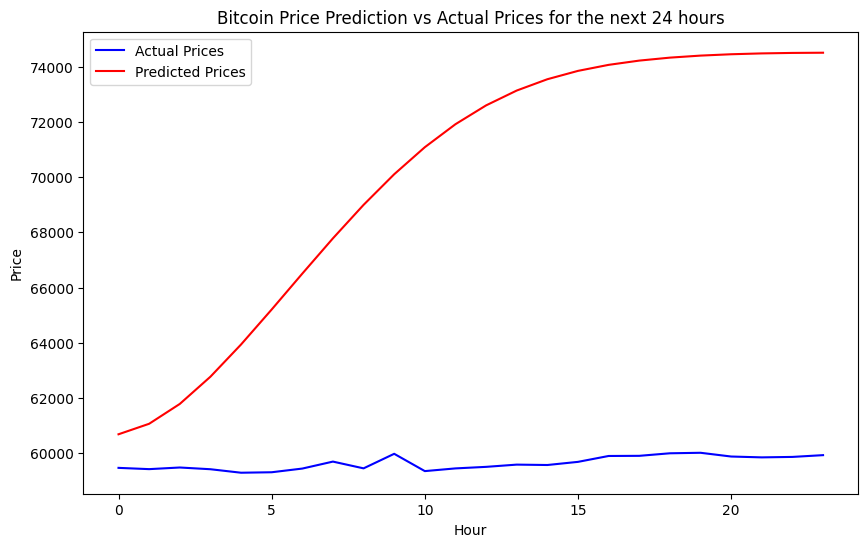

In [16]:
# Plot the actual and predicted prices
plt.figure(figsize=(10, 6))
plt.plot(range(future_hours), actual_prices, label='Actual Prices', color='blue')
plt.plot(range(future_hours), predicted_prices, label='Predicted Prices', color='red')
plt.title(f'Bitcoin Price Prediction vs Actual Prices for the next {future_hours} hours')
plt.xlabel('Hour')
plt.ylabel('Price')
plt.legend()
plt.show()


In [17]:
# Calculate actual tendency (up/down) between consecutive hours
actual_tendency = np.diff(actual_prices) > 0  # True if price goes up, False if it goes down

# Calculate predicted tendency (up/down) between consecutive hours
predicted_tendency = np.diff(predicted_prices) > 0  # True if predicted price goes up, False if it goes down

# Create a DataFrame to store the results
tendency_table = pd.DataFrame({
    'Predicted Tendency': ['Up' if pred else 'Down' for pred in predicted_tendency],
    'Actual Tendency': ['Up' if actual else 'Down' for actual in actual_tendency],
    'Result': ['Correct' if correct else 'Wrong' for correct in (predicted_tendency == actual_tendency)]
})

# Add corresponding price information for better clarity
tendency_table['Price Change (Predicted)'] = [f'{predicted_prices[i]:.4f} to {predicted_prices[i+1]:.4f}' for i in range(len(predicted_prices) - 1)]
tendency_table['Price Change (Actual)'] = [f'{actual_prices[i]:.4f} to {actual_prices[i+1]:.4f}' for i in range(len(actual_prices) - 1)]

# Reorder columns for clarity
tendency_table = tendency_table[['Price Change (Predicted)', 'Price Change (Actual)', 'Predicted Tendency', 'Actual Tendency', 'Result']]

# Display the table
tendency_table



,Price Change (Predicted),Price Change (Actual),Predicted Tendency,Actual Tendency,Result
0,60687.4835 to 61067.8444,59471.5742 to 59425.5586,Up,Down,Wrong
1,61067.8444 to 61785.5980,59425.5586 to 59484.7500,Up,Up,Correct
2,61785.5980 to 62771.1378,59484.7500 to 59422.2344,Up,Down,Wrong
3,62771.1378 to 63937.8301,59422.2344 to 59295.7500,Up,Down,Wrong
4,63937.8301 to 65204.5098,59295.7500 to 59312.6680,Up,Up,Correct
5,65204.5098 to 66503.8765,59312.6680 to 59446.2617,Up,Up,Correct
6,66503.8765 to 67781.5486,59446.2617 to 59698.6055,Up,Up,Correct
7,67781.5486 to 68992.9628,59698.6055 to 59453.8125,Up,Down,Wrong
8,68992.9628 to 70101.8142,59453.8125 to 59980.6016,Up,Up,Correct
9,70101.8142 to 71080.7876,59980.6016 to 59354.2852,Up,Down,Wrong


In [18]:
# Compare tendencies
tendency_correct = actual_tendency == predicted_tendency

# Calculate the accuracy of tendency prediction
tendency_accuracy = np.mean(tendency_correct) * 100  # In percentage

# Calculate the number of correct and incorrect tendencies
correct_tendencies = np.sum(tendency_correct)
incorrect_tendencies = len(tendency_correct) - correct_tendencies

# Create a DataFrame to display the results
results_table = pd.DataFrame({
    'Metric': ['Correct Tendencies', 'Incorrect Tendencies', 'Tendency Accuracy (%)'],
    'Value': [correct_tendencies, incorrect_tendencies, f'{tendency_accuracy:.2f}%']
})

results_table


,Metric,Value
0,Correct Tendencies,15
1,Incorrect Tendencies,8
2,Tendency Accuracy (%),65.22%
